# Saque de uma Bola de Volei
### Projeto 3 - Sistema Mecânico
-----
- Alex Pacchioni
- Beatriz Rodrigues
- Maria Vitória Sartori
- Rafael Dourado

#### Bibliotecas e Funções Básicas

In [2]:
# Importa bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from math import *
from scipy.integrate import odeint

In [3]:
# Função para deixar os eixos 3D igual (equivalente ao plt.axes('equal'))
def set_axis_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)
    
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([0, z_middle + plot_radius])
# Fonte: https://stackoverflow.com/questions/13685386/matplotlib-equal-unit-length-with-equal-aspect-ratio-z-axis-is-not-equal-to

#### Parâmetros

In [4]:
d_ar = 1.2 # Densidade do Ar [kg/m³]
g = 9.8 # Aceleração da Gravidade [m/s]

cl = 1 # Coeficiente de Lift (Magnus)
cd = 0.1 # Coeficiente de Arrasto

r = 0.105 # Raio da Bola [m]
m = 0.27 # Massa da Bola [kg]
A = pi*(r**2) # Álea Transversal da Bola [m²]

#### A Quadra de Volei

In [5]:
# Quadra: 9 mestros de largula por 18 metros de comprimento
# Rede: 2,43 metros de altura, localizada no meio da quadra (9 metros)

quadra_x = [0, 18, 18, 0, 0]
quadra_y = [-4.5, -4.5, 4.5, 4.5, -4.5]
quadra_z = [0, 0, 0, 0, 0]

rede_x = [9, 9, 9, 9, 9]
rede_y = [-4.5, -4.5, 4.5, 4.5, -4.5]
rede_z = [1.43, 2.43, 2.43, 1.43, 1.43]

#### Dados do Vídeo

In [6]:
import pandas
colunas = ['t', 'x', 'y']
data = pandas.read_csv('dados-volei.txt', names=colunas)

t_video = data.t.tolist()
t_video = list(np.array(t_video)-t_video[0])
x_video = data.x.tolist()
y_video = data.y.tolist()

#### Declarações iniciais

In [7]:
# Ângulos iniciais
tetha = radians(90) # Ângulo vertical
alpha = radians(15) # Ângulo horizontal

# Posição inicial
x0 = 0
y0 = y_video[0]
z0 = 3 # Nesse sistema, a altura está no eixo Z

# Decompondo a Velocidade inicial
v0 = 126.3/3.6 # dado em [km/h] transformado em [m/s]
vx0 = v0*sin(tetha)*cos(alpha)
vy0 = v0*sin(tetha)*sin(alpha)
vz0 = v0*cos(tetha)

# Decompondo a Velocidade Angular inicial
w = 7*(2*pi) # dado em [RPS] transformado em [rad]
wx = -w*sin(tetha)*sin(alpha)
wy = w*sin(tetha)*cos(alpha)
wz = w*cos(tetha)
w_vetor = np.array([wx, wy, wz]) # Compondo o Vetor da velocidade angular

# Valores iniciais
info_0 = [x0, y0, z0, vx0, vy0, vz0]

In [8]:
# Definindo o Tempo
dt = 1e-3
tMax = 1+dt
t_lista = np.arange(0, tMax, dt)

#### Modelo

In [9]:
def modelo(info, t_lista):
    # Extraindo os Valores
    x = info[0]
    y = info[1]
    z = info[2]
    vx = info[3]
    vy = info[4]
    vz = info[5]

    v_vetor = np.array([vx, vy, vz]) # Compondo o vetor da velocidade
    
    v_xy = sqrt(vx**2 + vy**2) # Componente da velocidade em xy
    v = sqrt(v_xy**2 + vz**2) # Velocidade

    # Calculos dos ângulos
    cos_tetha = vz/v 
    sen_tetha = v_xy/v
    cos_alpha = vx/v_xy
    sen_alpha = vy/v_xy

    # Calculando a Força de Arrasto
    Fa = 0.5*d_ar*A*cd*(v**2)
    Fa_x = -Fa*sen_tetha*cos_alpha
    Fa_y = -Fa*sen_tetha*sen_alpha
    Fa_z = -Fa*cos_tetha
    
    # Calculando a Força Magnus
    Fmag = d_ar*pi*(r**3)*cl*np.cross(w_vetor, v_vetor)
    Fmag_x = Fmag[0]
    Fmag_y = Fmag[1]
    Fmag_z = Fmag[2]
    
    # Calculando a aceleração (dV_dt)
    dVx_dt = (Fa_x + Fmag_x)/m
    dVy_dt = (Fa_y + Fmag_y)/m
    dVz_dt = (-(m*g) + Fa_z + Fmag_z)/m

    if z <= 0: # Impedindo a bola de atravessar o chão
        return [0, 0, 0, 0 ,0 ,0]
    else:
        return [vx, vy, vz, dVx_dt ,dVy_dt ,dVz_dt]

#### Validação

Tempo para passar da rede: 0.277s
Tempo para bater no chão: 0.539s
Posição final em X: 16.85m
Posição final em Y: 1.68m
Posição final em Z: -0.0m
Erro Percentual do Modelo: 7.782101167315182%


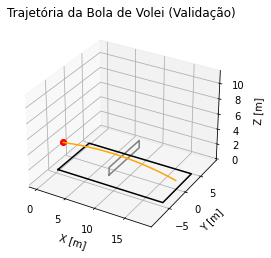

In [10]:
infos_Odeint = odeint(modelo, info_0, t_lista)

posX = list(infos_Odeint[:,0])
posY = list(infos_Odeint[:,1])
posZ = list(infos_Odeint[:,2])


rede = False
index = len(t_lista)-1 # index do ultimo valor do modelo (valor em que a bola bate no chão)
for i, t in enumerate(t_lista):
    if not rede and (posX[i] >= 9):
        tempo_rede = t
        rede = True
    if rede and (posZ[i] <= 0 and posX[i] <= 18):
        tempo_chao = t
        index = i
        break

print(f'Tempo para passar da rede: {round(tempo_rede, 3)}s')
print(f'Tempo para bater no chão: {round(tempo_chao, 3)}s')    
print(f'Posição final em X: {round(posX[index], 2)}m')
print(f'Posição final em Y: {round(posY[index], 2)}m')
print(f'Posição final em Z: {round(posZ[index], 2)}m')
dado_tempo_rede = 0.257 # tempo decorrido para bater na rede pego no vídeo
erro = ((tempo_rede - dado_tempo_rede)/dado_tempo_rede)*100
print(f'\nErro Percentual do Modelo: {round(erro, 3)}%')

%matplotlib inline
# %matplotlib qt5

ax = plt.axes(projection='3d')
ax.plot3D(rede_x, rede_y, rede_z, color='grey') # rede
ax.plot3D(quadra_x, quadra_y, quadra_z, color='black') # quadra
ax.plot3D(posX[0], posY[0], posZ[0], 'ro') # Bola

ax.plot3D(posX[0:index], posY[0: index], posZ[0: index], color="orange")
plt.title("Trajetória da Bola de Volei (Validação)")
plt.grid()
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
set_axis_equal(ax)
plt.show()

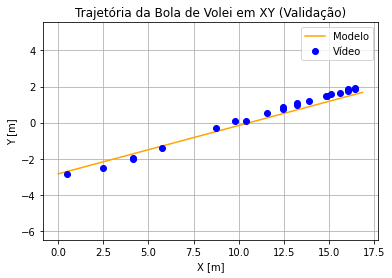

In [11]:
%matplotlib inline
# Validação do modelo usando os dados coletados do Vídeo
plt.plot(posX, posY, color='orange', label='Modelo')
plt.plot(x_video, y_video, 'bo', label='Vídeo')
plt.title("Trajetória da Bola de Volei em XY (Validação)")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.grid()
plt.legend()
plt.axis("equal")
plt.show()

#### Implementação

In [12]:
# Valores Ideais paras as váriaveis
# Esses conjunto de valores é um dos capazes de fazer a bola passar pela rede e cair na quadra adversária

w_ideal = 8 # Velocidade Angular [RPS]
v_ideal = 100 # Velocidade Inicial[km/h]
z_ideal = 3.1 # Altura Inicial[m]
tetha_ideal = 85 # Ângulo Vertical Inicial [°]
alpha_ideal = 10 # Ângulo horizontal Inicial [°]

c:\Users\Rafael Dourado\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Tempo para passar da rede: 0.343s
Tempo para bater no chão: 0.691s
Posição final em X: 17.31m
Posição final em Y: 0.27m
Posição final em Z: -0.0m


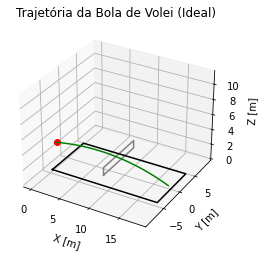

In [13]:
# Ângulos iniciais
tetha = radians(tetha_ideal) # Ângulo vertical
alpha = radians(alpha_ideal) # Ângulo horizontal

# Posição inicial
x0 = 0
y0 = -3
z0 = z_ideal # Nesse sistema, a altura está no eixo Z

# Decompondo a Velocidade inicial
v0 = v_ideal/3.6 # dado em [km/h] transformado em [m/s]
vx0 = v0*sin(tetha)*cos(alpha)
vy0 = v0*sin(tetha)*sin(alpha)
vz0 = v0*cos(tetha)

# Decompondo a Velocidade Angular inicial
w = w_ideal*(2*pi) # dado em [RPS] transformado em [rad]
wx = -w*sin(tetha)*sin(alpha)
wy = w*sin(tetha)*cos(alpha)
wz = w*cos(tetha)
w_vetor = np.array([wx, wy, wz]) # Compondo o Vetor da velocidade angular

# Valores iniciais
info_0 = [x0, y0, z0, vx0, vy0, vz0]

infos_Odeint = odeint(modelo, info_0, t_lista)

posX = list(infos_Odeint[:,0])
posY = list(infos_Odeint[:,1])
posZ = list(infos_Odeint[:,2])

tempo_rede = 0
tempo_chao = 0

cor = 'red'
rede = False
index = len(t_lista)-1 # index do ultimo valor do modelo (valor em que a bola bate no chão)
for i, t in enumerate(t_lista):
    if not rede and (posX[i] >= 9):
        tempo_rede = t
        cor = 'yellow'
        rede = True
    if rede and (posZ[i] <= 0 and posX[i] <= 18):
        tempo_chao = t
        cor = 'green'
        index = i
        break

print(f'Tempo para passar da rede: {round(tempo_rede, 3)}s')
print(f'Tempo para bater no chão: {round(tempo_chao, 3)}s')    
print(f'Posição final em X: {round(posX[index], 2)}m')
print(f'Posição final em Y: {round(posY[index], 2)}m')
print(f'Posição final em Z: {round(posZ[index], 2)}m')

%matplotlib inline
# %matplotlib qt5

ax = plt.axes(projection='3d')
ax.plot3D(rede_x, rede_y, rede_z, color='grey') # rede
ax.plot3D(quadra_x, quadra_y, quadra_z, color='black') # quadra
ax.plot3D(posX[0], posY[0], posZ[0], 'ro') # Bola

ax.plot3D(posX[0:index], posY[0: index], posZ[0: index], color=cor)
plt.title("Trajetória da Bola de Volei (Ideal)")
plt.grid()
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
set_axis_equal(ax)
plt.show()

#### Gráficos Conclusivos

In [14]:
# lista de Velocidades Angulares
dw = 0.5
lista_w = np.arange(3, 10+dw, dw)*(2*pi)
# lista de Velocidades iniciais
dv = 1
lista_v = np.arange(100, 130+dv, dv)
# lista de Alturas iniciais
dz = 0.02
lista_z = np.arange(3, 3.2+dz, dz)
# lista de Ângulos Verticais Iniciais
dtetha = 1
lista_tetha = np.arange(85, 95+dtetha, dtetha)
# lista de Ângulos Horizontais Iniciais
dalpha = 1
lista_alpha = np.arange(10, 20+dalpha, dalpha)

In [15]:
# Altera a cor da dependendo se a bola passou da rede e bateu no chão da quadra
def verifica(posX, posZ):
    rede = False
    cor = 'ro'
    for i, t in enumerate(t_lista):
        if not rede and (posX[i] >= 9 and posZ[i]-r >= 2.43):
            rede = True
            cor = 'yo'
        if rede and (posZ[i] <= 0 and posX[i] <= 18):
            cor = 'go'
            break
    return cor

# Legenda:
# Vermelho: Não passou da rede
# Amarelo: Passou da rede, mas caiu fora da quadra
# Verde: Passou da rede e cai dentro da quadra

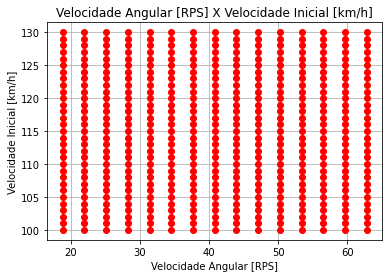

In [16]:
for W in lista_w:
    for V in lista_v:

        # Ângulos iniciais
        tetha = radians(tetha_ideal) # Ângulo vertical
        alpha = radians(alpha_ideal) # Ângulo horizontal

        # Posição inicial
        x0 = 0
        y0 = -3
        z0 = z_ideal # Nesse sistema, a altura está no eixo Z

        # Decompondo a Velocidade inicial
        v0 = V/3.6 # dado em [km/h] transformado em [m/s]
        vx0 = v0*sin(tetha)*cos(alpha)
        vy0 = v0*sin(tetha)*sin(alpha)
        vz0 = v0*cos(tetha)

        # Decompondo a Velocidade Angular inicial
        w = W*(2*pi) # dado em [RPS] transformado em [rad]
        wx = -w*sin(tetha)*sin(alpha)
        wy = w*sin(tetha)*cos(alpha)
        wz = w*cos(tetha)
        w_vetor = np.array([wx, wy, wz]) # Compondo o Vetor da velocidade angular

        # Valores iniciais
        info_0 = [x0, y0, z0, vx0, vy0, vz0]

        infos_Odeint = odeint(modelo, info_0, t_lista)

        posX = list(infos_Odeint[:,0])
        posY = list(infos_Odeint[:,1])
        posZ = list(infos_Odeint[:,2])

        cor = verifica(posX, posZ)

        plt.plot(W, V, cor)
plt.title("Velocidade Angular [RPS] X Velocidade Inicial [km/h]")
plt.xlabel('Velocidade Angular [RPS]')
plt.ylabel('Velocidade Inicial [km/h]')
plt.grid()
plt.show()

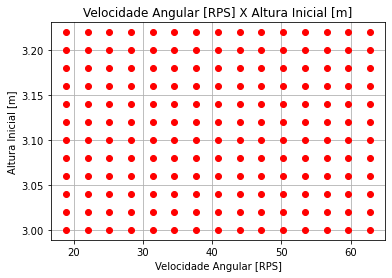

In [17]:
for W in lista_w:
    for z in lista_z:
        
        # Ângulos iniciais
        tetha = radians(tetha_ideal) # Ângulo vertical
        alpha = radians(alpha_ideal) # Ângulo horizontal

        # Posição inicial
        x0 = 0
        y0 = -3
        z0 = z # Nesse sistema, a altura está no eixo Z

        # Decompondo a Velocidade inicial
        v0 = v_ideal/3.6 # dado em [km/h] transformado em [m/s]
        vx0 = v0*sin(tetha)*cos(alpha)
        vy0 = v0*sin(tetha)*sin(alpha)
        vz0 = v0*cos(tetha)

        # Decompondo a Velocidade Angular inicial
        w = W*(2*pi) # dado em [RPS] transformado em [rad]
        wx = -w*sin(tetha)*sin(alpha)
        wy = w*sin(tetha)*cos(alpha)
        wz = w*cos(tetha)
        w_vetor = np.array([wx, wy, wz]) # Compondo o Vetor da velocidade angular

        # Valores iniciais
        info_0 = [x0, y0, z0, vx0, vy0, vz0]

        infos_Odeint = odeint(modelo, info_0, t_lista)

        posX = list(infos_Odeint[:,0])
        posY = list(infos_Odeint[:,1])
        posZ = list(infos_Odeint[:,2])

        cor = verifica(posX, posZ)

        plt.plot(W, z, cor)
plt.title("Velocidade Angular [RPS] X Altura Inicial [m]")
plt.xlabel('Velocidade Angular [RPS]')
plt.ylabel('Altura Inicial [m]')
plt.grid()
plt.show()

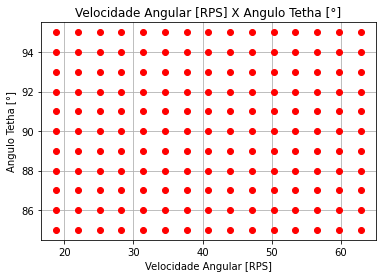

In [18]:
for W in lista_w:
    for ang_tetha in lista_tetha:
        
        # Ângulos iniciais
        tetha = radians(ang_tetha) # Ângulo vertical
        alpha = radians(alpha_ideal) # Ângulo horizontal

        # Posição inicial
        x0 = 0
        y0 = -3
        z0 = z_ideal # Nesse sistema, a altura está no eixo Z

        # Decompondo a Velocidade inicial
        v0 = v_ideal/3.6 # dado em [km/h] transformado em [m/s]
        vx0 = v0*sin(tetha)*cos(alpha)
        vy0 = v0*sin(tetha)*sin(alpha)
        vz0 = v0*cos(tetha)

        # Decompondo a Velocidade Angular inicial
        w = W*(2*pi) # dado em [RPS] transformado em [rad]
        wx = -w*sin(tetha)*sin(alpha)
        wy = w*sin(tetha)*cos(alpha)
        wz = w*cos(tetha)
        w_vetor = np.array([wx, wy, wz]) # Compondo o Vetor da velocidade angular

        # Valores iniciais
        info_0 = [x0, y0, z0, vx0, vy0, vz0]

        infos_Odeint = odeint(modelo, info_0, t_lista)

        posX = list(infos_Odeint[:,0])
        posY = list(infos_Odeint[:,1])
        posZ = list(infos_Odeint[:,2])

        cor = verifica(posX, posZ)

        plt.plot(W, ang_tetha, cor)
plt.title("Velocidade Angular [RPS] X Angulo Tetha [°]")
plt.xlabel('Velocidade Angular [RPS]')
plt.ylabel('Angulo Tetha [°]')
plt.grid()
plt.show()

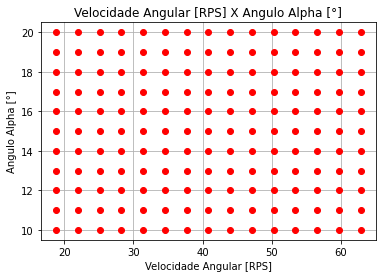

In [19]:
for W in lista_w:
    for ang_alpha in lista_alpha:
        
        # Ângulos iniciais
        tetha = radians(tetha_ideal) # Ângulo vertical
        alpha = radians(ang_alpha) # Ângulo horizontal

        # Posição inicial
        x0 = 0
        y0 = -3
        z0 = z_ideal # Nesse sistema, a altura está no eixo Z

        # Decompondo a Velocidade inicial
        v0 = v_ideal/3.6 # dado em [km/h] transformado em [m/s]
        vx0 = v0*sin(tetha)*cos(alpha)
        vy0 = v0*sin(tetha)*sin(alpha)
        vz0 = v0*cos(tetha)

        # Decompondo a Velocidade Angular inicial
        w = W*(2*pi) # dado em [RPS] transformado em [rad]
        wx = -w*sin(tetha)*sin(alpha)
        wy = w*sin(tetha)*cos(alpha)
        wz = w*cos(tetha)
        w_vetor = np.array([wx, wy, wz]) # Compondo o Vetor da velocidade angular

        # Valores iniciais
        info_0 = [x0, y0, z0, vx0, vy0, vz0]

        infos_Odeint = odeint(modelo, info_0, t_lista)

        posX = list(infos_Odeint[:,0])
        posY = list(infos_Odeint[:,1])
        posZ = list(infos_Odeint[:,2])

        cor = verifica(posX, posZ)

        plt.plot(W, ang_alpha, cor)
plt.title("Velocidade Angular [RPS] X Angulo Alpha [°]")
plt.xlabel('Velocidade Angular [RPS]')
plt.ylabel('Angulo Alpha [°]')
plt.grid()
plt.show()

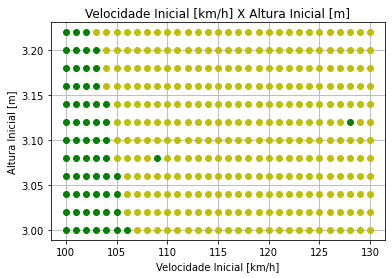

In [20]:
for V in lista_v:
    for z in lista_z:
        
        # Ângulos iniciais
        tetha = radians(tetha_ideal) # Ângulo vertical
        alpha = radians(alpha_ideal) # Ângulo horizontal

        # Posição inicial
        x0 = 0
        y0 = -3
        z0 = z # Nesse sistema, a altura está no eixo Z

        # Decompondo a Velocidade inicial
        v0 = V/3.6 # dado em [km/h] transformado em [m/s]
        vx0 = v0*sin(tetha)*cos(alpha)
        vy0 = v0*sin(tetha)*sin(alpha)
        vz0 = v0*cos(tetha)

        # Decompondo a Velocidade Angular inicial
        w = w_ideal*(2*pi) # dado em [RPS] transformado em [rad]
        wx = -w*sin(tetha)*sin(alpha)
        wy = w*sin(tetha)*cos(alpha)
        wz = w*cos(tetha)
        w_vetor = np.array([wx, wy, wz]) # Compondo o Vetor da velocidade angular

        # Valores iniciais
        info_0 = [x0, y0, z0, vx0, vy0, vz0]

        infos_Odeint = odeint(modelo, info_0, t_lista)

        posX = list(infos_Odeint[:,0])
        posY = list(infos_Odeint[:,1])
        posZ = list(infos_Odeint[:,2])

        cor = verifica(posX, posZ)

        plt.plot(V, z, cor)
plt.title("Velocidade Inicial [km/h] X Altura Inicial [m]")
plt.xlabel('Velocidade Inicial [km/h]')
plt.ylabel('Altura Inicial [m]')
plt.grid()
plt.show()

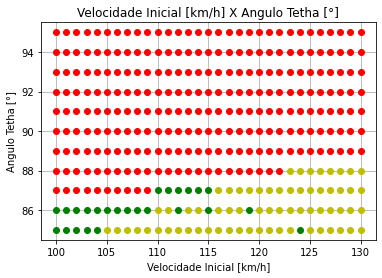

In [21]:
for V in lista_v:
    for ang_tetha in lista_tetha:
        
        # Ângulos iniciais
        tetha = radians(ang_tetha) # Ângulo vertical
        alpha = radians(alpha_ideal) # Ângulo horizontal

        # Posição inicial
        x0 = 0
        y0 = -3
        z0 = z_ideal # Nesse sistema, a altura está no eixo Z

        # Decompondo a Velocidade inicial
        v0 = V/3.6 # dado em [km/h] transformado em [m/s]
        vx0 = v0*sin(tetha)*cos(alpha)
        vy0 = v0*sin(tetha)*sin(alpha)
        vz0 = v0*cos(tetha)

        # Decompondo a Velocidade Angular inicial
        w = w_ideal*(2*pi) # dado em [RPS] transformado em [rad]
        wx = -w*sin(tetha)*sin(alpha)
        wy = w*sin(tetha)*cos(alpha)
        wz = w*cos(tetha)
        w_vetor = np.array([wx, wy, wz]) # Compondo o Vetor da velocidade angular

        # Valores iniciais
        info_0 = [x0, y0, z0, vx0, vy0, vz0]

        infos_Odeint = odeint(modelo, info_0, t_lista)

        posX = list(infos_Odeint[:,0])
        posY = list(infos_Odeint[:,1])
        posZ = list(infos_Odeint[:,2])

        cor = verifica(posX, posZ)

        plt.plot(V, ang_tetha, cor)
plt.title("Velocidade Inicial [km/h] X Angulo Tetha [°]")
plt.xlabel('Velocidade Inicial [km/h]')
plt.ylabel('Angulo Tetha [°]')
plt.grid()
plt.show()

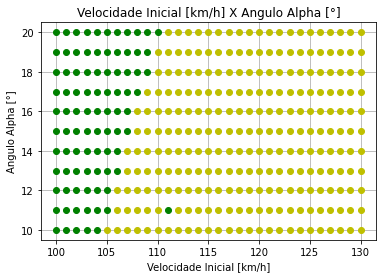

In [22]:
for V in lista_v:
    for ang_alpha in lista_alpha:
        
        # Ângulos iniciais
        tetha = radians(tetha_ideal) # Ângulo vertical
        alpha = radians(ang_alpha) # Ângulo horizontal

        # Posição inicial
        x0 = 0
        y0 = -3
        z0 = z_ideal # Nesse sistema, a altura está no eixo Z

        # Decompondo a Velocidade inicial
        v0 = V/3.6 # dado em [km/h] transformado em [m/s]
        vx0 = v0*sin(tetha)*cos(alpha)
        vy0 = v0*sin(tetha)*sin(alpha)
        vz0 = v0*cos(tetha)

        # Decompondo a Velocidade Angular inicial
        w = w_ideal*(2*pi) # dado em [RPS] transformado em [rad]
        wx = -w*sin(tetha)*sin(alpha)
        wy = w*sin(tetha)*cos(alpha)
        wz = w*cos(tetha)
        w_vetor = np.array([wx, wy, wz]) # Compondo o Vetor da velocidade angular

        # Valores iniciais
        info_0 = [x0, y0, z0, vx0, vy0, vz0]

        infos_Odeint = odeint(modelo, info_0, t_lista)

        posX = list(infos_Odeint[:,0])
        posY = list(infos_Odeint[:,1])
        posZ = list(infos_Odeint[:,2])

        cor = verifica(posX, posZ)

        plt.plot(V, ang_alpha, cor)
plt.title("Velocidade Inicial [km/h] X Angulo Alpha [°]")
plt.xlabel('Velocidade Inicial [km/h]')
plt.ylabel('Angulo Alpha [°]')
plt.grid()
plt.show()

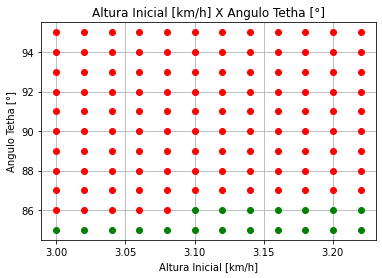

In [23]:
for z in lista_z:
    for ang_tetha in lista_tetha:
        
        # Ângulos iniciais
        tetha = radians(ang_tetha) # Ângulo vertical
        alpha = radians(alpha_ideal) # Ângulo horizontal

        # Posição inicial
        x0 = 0
        y0 = -3
        z0 = z # Nesse sistema, a altura está no eixo Z

        # Decompondo a Velocidade inicial
        v0 = v_ideal/3.6 # dado em [km/h] transformado em [m/s]
        vx0 = v0*sin(tetha)*cos(alpha)
        vy0 = v0*sin(tetha)*sin(alpha)
        vz0 = v0*cos(tetha)

        # Decompondo a Velocidade Angular inicial
        w = w_ideal*(2*pi) # dado em [RPS] transformado em [rad]
        wx = -w*sin(tetha)*sin(alpha)
        wy = w*sin(tetha)*cos(alpha)
        wz = w*cos(tetha)
        w_vetor = np.array([wx, wy, wz]) # Compondo o Vetor da velocidade angular

        # Valores iniciais
        info_0 = [x0, y0, z0, vx0, vy0, vz0]

        infos_Odeint = odeint(modelo, info_0, t_lista)

        posX = list(infos_Odeint[:,0])
        posY = list(infos_Odeint[:,1])
        posZ = list(infos_Odeint[:,2])

        cor = verifica(posX, posZ)

        plt.plot(z, ang_tetha, cor)
plt.title("Altura Inicial [km/h] X Angulo Tetha [°]")
plt.xlabel('Altura Inicial [km/h]')
plt.ylabel('Angulo Tetha [°]')
plt.grid()
plt.show()

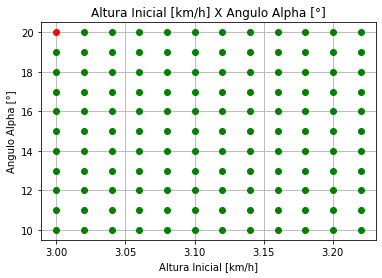

In [24]:
for z in lista_z:
    for ang_alpha in lista_alpha:
        
        # Ângulos iniciais
        tetha = radians(tetha_ideal) # Ângulo vertical
        alpha = radians(ang_alpha) # Ângulo horizontal

        # Posição inicial
        x0 = 0
        y0 = -3
        z0 = z # Nesse sistema, a altura está no eixo Z

        # Decompondo a Velocidade inicial
        v0 = v_ideal/3.6 # dado em [km/h] transformado em [m/s]
        vx0 = v0*sin(tetha)*cos(alpha)
        vy0 = v0*sin(tetha)*sin(alpha)
        vz0 = v0*cos(tetha)

        # Decompondo a Velocidade Angular inicial
        w = w_ideal*(2*pi) # dado em [RPS] transformado em [rad]
        wx = -w*sin(tetha)*sin(alpha)
        wy = w*sin(tetha)*cos(alpha)
        wz = w*cos(tetha)
        w_vetor = np.array([wx, wy, wz]) # Compondo o Vetor da velocidade angular

        # Valores iniciais
        info_0 = [x0, y0, z0, vx0, vy0, vz0]

        infos_Odeint = odeint(modelo, info_0, t_lista)

        posX = list(infos_Odeint[:,0])
        posY = list(infos_Odeint[:,1])
        posZ = list(infos_Odeint[:,2])

        cor = verifica(posX, posZ)

        plt.plot(z, ang_alpha, cor)
plt.title("Altura Inicial [km/h] X Angulo Alpha [°]")
plt.xlabel('Altura Inicial [km/h]')
plt.ylabel('Angulo Alpha [°]')
plt.grid()
plt.show()

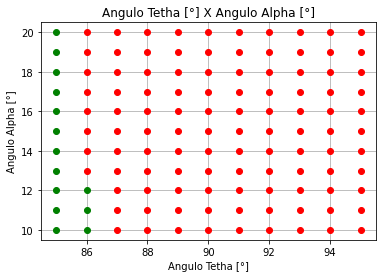

In [25]:
for ang_tetha in lista_tetha:
    for ang_alpha in lista_alpha:
        
        # Ângulos iniciais
        tetha = radians(ang_tetha) # Ângulo vertical
        alpha = radians(ang_alpha) # Ângulo horizontal

        # Posição inicial
        x0 = 0
        y0 = -3
        z0 = z_ideal # Nesse sistema, a altura está no eixo Z

        # Decompondo a Velocidade inicial
        v0 = v_ideal/3.6 # dado em [km/h] transformado em [m/s]
        vx0 = v0*sin(tetha)*cos(alpha)
        vy0 = v0*sin(tetha)*sin(alpha)
        vz0 = v0*cos(tetha)

        # Decompondo a Velocidade Angular inicial
        w = w_ideal*(2*pi) # dado em [RPS] transformado em [rad]
        wx = -w*sin(tetha)*sin(alpha)
        wy = w*sin(tetha)*cos(alpha)
        wz = w*cos(tetha)
        w_vetor = np.array([wx, wy, wz]) # Compondo o Vetor da velocidade angular

        # Valores iniciais
        info_0 = [x0, y0, z0, vx0, vy0, vz0]

        infos_Odeint = odeint(modelo, info_0, t_lista)

        posX = list(infos_Odeint[:,0])
        posY = list(infos_Odeint[:,1])
        posZ = list(infos_Odeint[:,2])

        cor = verifica(posX, posZ)

        plt.plot(ang_tetha, ang_alpha, cor)
plt.title("Angulo Tetha [°] X Angulo Alpha [°]")
plt.xlabel('Angulo Tetha [°]')
plt.ylabel('Angulo Alpha [°]')
plt.grid()
plt.show()